In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import collections
import matplotlib.pyplot as plt
import helper

In [420]:
def partial_shading(data):
    
    d_data = []
    
    num_partial_p = np.random.randint(2,6)

    percent = []
    for i in range(num_partial_p):
        if i % 2 == 0:
            level = np.random.uniform(0.1,0.5)
        else:
            level = 1
        percent.append(level)
        
    points = []
    for i in range(num_partial_p):
        points.append(np.random.randint(0,len(data)))
    points.sort()

    partial = {point:level for point, level in zip(points,percent)}
    
    d_data = []
    factor = []
    level = 1
        
    for j,j_data in enumerate(data):
        
        if j in partial:
            level = partial[j]            
        d_data.append(j_data*level*(1+np.random.normal(0,0.01)))  
        factor.append(level)
    
    return d_data,factor

def confusion_matrix_plot(cm,save=False):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1) 
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True,fmt='g',annot_kws={"size": 25},cmap="Blues", square=True, cbar=False)

    # labels, title and ticks
    ax.set_xlabel('Prediction',fontsize=30)
    ax.set_ylabel('Ground Truth',fontsize=30)
    ax.xaxis.set_ticklabels(['Normal (Noise)', 'Open Circuit', 'Object Cover'],fontsize=20)
    ax.yaxis.set_ticklabels(['Normal (Noise)', 'Open Circuit', 'Object Cover'],fontsize=20)

    plt.tight_layout()
    if save is True:
        plt.savefig('synthetic_experiment.jpg', format='jpg', dpi=1000)
    plt.show()

## Create Synthetic Data

In [421]:
class synthetic_data:
    def __init__(self,dataset):
        self.panel_record = {}
        self.defect_record = {}
        self.store_df = {}
        
        self.dataset = dataset
        self.dataset = self.dataset[self.dataset['label']=='normal']
        
        drop_col = [d_col for d_col in self.dataset.columns if d_col[:5] != 'panel' and d_col != 'date']
        self.dataset = self.dataset.drop(drop_col,axis=1)
        self.panels = [i for i in self.dataset.columns if i != 'date']
        
    def sample_index(self, data,origin_data):
        feature_index = []
        while len(feature_index) < len(origin_data):
            index = np.random.randint(0,len(data))
            if index not in feature_index:
                feature_index.append(index)
        feature_index.sort()
    
        return np.array(data)[feature_index]

    def leaf_feature(self, data):
        leaf_feature = pd.read_csv('leaf_cover.csv')
    
        one_leaf = leaf_feature[610:900]
        one_feature = one_leaf['power_1']/one_leaf['power_2'].values
        one_feature = self.sample_index(one_feature,data)

        two_leaf = leaf_feature[1570:1903]
        two_feature = two_leaf['power_1']/two_leaf['power_2'].values
        two_feature = self.sample_index(two_feature,data)

        three_leaf = leaf_feature[1964:2242]
        three_feature = three_leaf['power_1']/three_leaf['power_2'].values
        three_feature = self.sample_index(three_feature,data)

        four_leaf = leaf_feature[3006:3280]
        four_feature = four_leaf['power_1']/four_leaf['power_2'].values
        four_feature = self.sample_index(four_feature,data)

        five_leaf = leaf_feature[3344:3655]
        five_feature = five_leaf['power_1']/five_leaf['power_2'].values
        five_feature = self.sample_index(five_feature,data)
    
        return one_feature, two_feature, three_feature, four_feature, five_feature
        
    def dust_cover(self,data):
    
        d_data = []
        levels = []
    
        one_leaf, two_leaf, three_leaf, four_leaf, five_leaf = self.leaf_feature(data)
        level_feature = {1:one_leaf,2:two_leaf,3:three_leaf,4:four_leaf,5:five_leaf}
    
        leaf_num = np.random.randint(1,6)
        level = level_feature[leaf_num]
        
#         induce = random.choice([1,1,1,0,0,0,0,0,0,0])
#         if induce == 1:
#             first = np.random.randint(5,25)
#             second = np.random.randint(first,40)
        
#             level[:first] = 1+np.random.normal(0,0.01)
#             level[second:] = 1+np.random.normal(0,0.01)
    
        data = np.array(data)*level
    
        return data

    def normal_noise_data(self, data):
    
        d_data = []
        for i in data:
            d_data.append(i*(1+np.random.normal(0,0.05)))
        return d_data

    def open_circuit(self, data):
    
        d_data = []
        break_p = np.random.randint(0,0.7*len(data))
    
        levels = []
    
        for i, i_data in enumerate(data):
            if i < break_p:
                levels.append(1)
                d_data.append(i_data*(1+np.random.normal(0,0.01)))
            else:
                d_data.append(1+np.random.normal(0,1))
                levels.append(1+np.random.normal(0,0.01))
            
        return d_data, levels
        
    def induce_defect(self, dataset, day, d_panel):
        # Extract the power output of the defect panel on given day 
        data = self.dataset[self.dataset['date']==day].drop(['date'],axis=1)[d_panel].values
        # Define condition option
        cond = random.choice(['open','cover','normal'])
    
        if len(data) < 50 or max(data) < 70:
            return None
    
        # Record the defect panel 
        self.panel_record[day] = d_panel
    
        if cond == 'open':
            d_data,_ = self.open_circuit(data)
            # Record the type of defect 
            self.defect_record[day] = 'open'
        elif cond == 'normal':
            d_data = self.normal_noise_data(data)
            # Record the type of defect 
            self.defect_record[day] = 'normal'
        else:
            d_data = self.dust_cover(data)
            # Record the type of defect 
            self.defect_record[day] = 'cover'
            
        return d_data
            
    def generate_data(self):
        
        day_list = list(set(self.dataset['date']))
        
        while day_list:
    
            # Pop random day
            random.shuffle(day_list)
            day = day_list.pop()
    
            # Pop random panel
            random.shuffle(self.panels)
            d_panel = self.panels.pop()
            
            d_data = self.induce_defect(self.dataset,day,d_panel)
            
            if d_data is None:
                continue
                
            # Reassemble the normal panel and defect panel back to dataframe
            df = self.dataset[self.dataset['date']==day].drop(['date'],axis=1)
            df[d_panel] = d_data
            self.store_df[day] = df
            
            self.panels = [i for i in self.dataset.columns if i != 'date']
             
    def generate_feature(self):
        self.generate_data()
        
        day_list = [i for i in self.store_df]
        df_feature = pd.DataFrame()
        bad_day = []
        day_col = []
        count = 0

        for day in day_list:
            # Extract daily data
            data = self.store_df[day]
            day_col.append(day)
            panels = list(data.columns)
    
            # Recorded defect type
            defect = self.defect_record[day]
    
            diff_list = []
    
            # Check every panels
            for i in range(len(panels)):
                d_panel = panels[i]
                rest_panels = panels[:i]+panels[i+1:]
        
                # Whichever panel produce lowest power is the defect panel
                diff_list.append(sum(data[d_panel]))
        
            if defect != 'normal':    
                # Check if any synthetic data looks too similar to normal data
                if panels[diff_list.index(min(diff_list))] != self.panel_record[day]:
                    print("Bad day: {}".format(day))
                    bad_day.append(day)
        
            # Generate 40 feature 
            feature_index = []
            while len(feature_index) < 40:
                index = np.random.randint(0,len(data))
                if index not in feature_index:
                    feature_index.append(index)
            feature_index.sort()
    
            # Calculate feature
            d_th = diff_list.index(min(diff_list))
            d_power = data[panels[d_th]].values
            gt_power = data[panels[:d_th]+panels[d_th+1:]].mean(axis=1).values
    
            features = list(d_power[feature_index]/gt_power[feature_index])
    
            if defect == 'normal':
                features.append(1)
            elif defect == 'open':
                features.append(2)
            else:
                features.append(3)
    
            df_feature = df_feature.append(pd.Series(features), ignore_index=True)

        df_feature['date'] = day_col

        for day in bad_day:
            index = df_feature[df_feature['date'] == day].index[0]
            df_feature.loc[index] = np.float64('nan')
    
        df_feature = df_feature.replace([np.inf, -np.inf], np.nan).dropna()
        
        return df_feature
        
dataset = pd.read_csv('east_data_clean.csv')
synthetic = synthetic_data(dataset)
df_feature = synthetic.generate_feature()

## Generate Features 

In [ ]:
# export_csv = df_feature.to_csv ("synthetic_feature.csv", index = False, header=True) 
# export_csv = df_feature.to_csv ("synthetic_feature.csv", index = False, header=True) 

## Classify the Defects 

In [422]:
import helper
model = helper.modeling()
scores, cm, rf_model,X_test,y_test,test_date = model.random_forest_class(df_feature)
scores

[97.14285714285714, 98.52941176470588, 95.58823529411765]

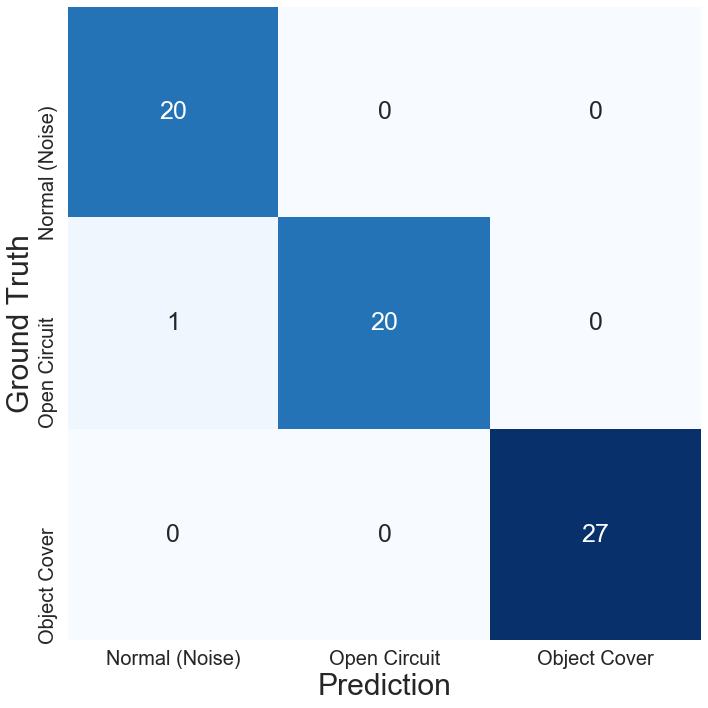

In [423]:
confusion_matrix_plot(cm[1],False)